In [1]:
from zipfile import ZipFile
file_name = '/content/Final-Year-Project.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 3  # number of dimensions

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0, 0.5, 1.0])[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, layers, mode, activation)

n_iter = 2*10**4
lr = 1e-3

In [4]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 6.499e+02, Y0: 0.104, Time: 0.92, Learning Rate: 1.000e-03
It: 100, Loss: 1.152e+01, Y0: 1.152, Time: 24.40, Learning Rate: 1.000e-03
It: 200, Loss: 5.736e+00, Y0: 1.080, Time: 24.35, Learning Rate: 1.000e-03
It: 300, Loss: 8.215e+00, Y0: 1.067, Time: 24.50, Learning Rate: 1.000e-03
It: 400, Loss: 5.840e+00, Y0: 1.026, Time: 24.25, Learning Rate: 1.000e-03
It: 500, Loss: 8.192e+00, Y0: 1.078, Time: 24.47, Learning Rate: 1.000e-03
It: 600, Loss: 5.663e+00, Y0: 1.072, Time: 24.77, Learning Rate: 1.000e-03
It: 700, Loss: 2.927e+00, Y0: 1.073, Time: 24.67, Learning Rate: 1.000e-03
It: 800, Loss: 3.336e+00, Y0: 1.036, Time: 24.56, Learning Rate: 1.000e-03
It: 900, Loss: 2.851e+00, Y0: 1.070, Time: 24.35, Learning Rate: 1.000e-03
It: 1000, Loss: 3.813e+00, Y0: 1.169, Time: 25.22, Learning Rate: 1.000e-03
It: 1100, Loss: 8.166e-01, Y0: 1.101, Time: 25.20, Learning Rate: 1.000e-03
It: 1200, Loss: 6.492e+00, Y0: 1.147, Time: 24.27, Learning Rate: 1.000e-03
It: 1300, Loss: 6.

In [5]:
model.load_model("models/3D_Call_Options_Basket.pth")

In [6]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)
samples = 5

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                    [M, -1, 1])

In [7]:
graph = np.stack((model.iteration, model.training_loss))

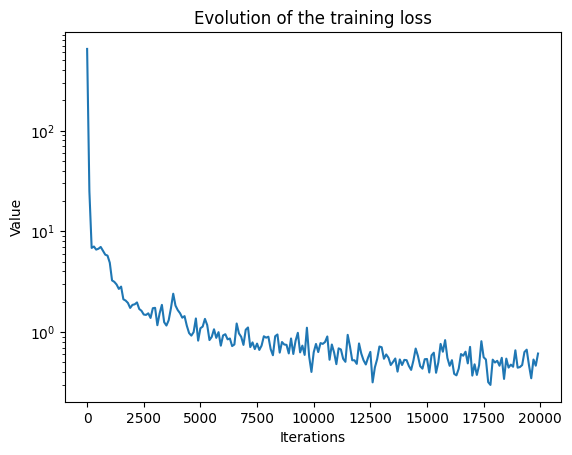

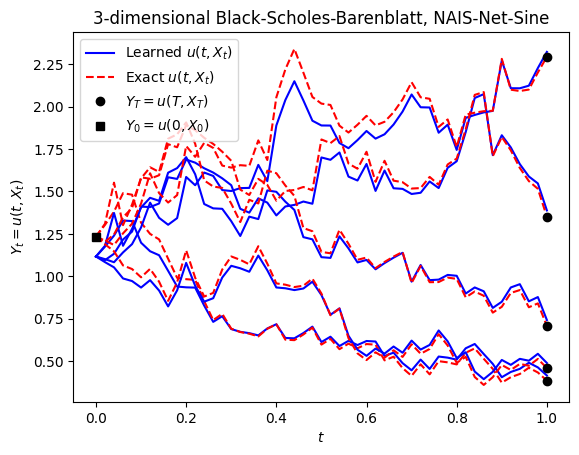

In [8]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

/tmp/ipykernel_2672563/290166100.py:1: RuntimeWarning: divide by zero encountered in divide
  errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
/vol/bitbucket/aan120/myvenv/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


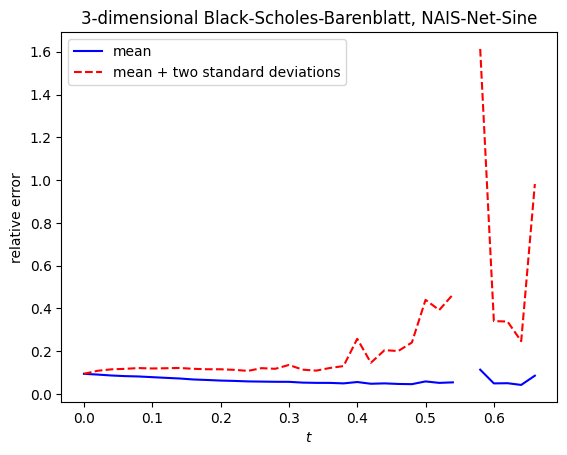

In [9]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)

plt.figure()
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.show()